Детектор аномалии на принципе многократной прогонки реконструкции входного образца до сходимости латентного вектора.
Критерий аномальности - расстояние от первоначального латентного вектора до сошедшего.

In [62]:
from dataclasses import dataclass
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchfuzzy import FuzzyLayer, DefuzzyLinearLayer, FuzzyBellLayer
import piqa
import sklearn.metrics as metrics
from sklearn.manifold import TSNE
from torchvision.transforms import v2

In [63]:
batch_size = 256
learning_rate = 2e-3
num_epochs = 300
latent_dim = 15
mnist_class_anomaly = 4
kernels = 2
fuzzy_rules_count = 21

prefix = f"fuzzy_cvae_mamdani_anomaly"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ssim = piqa.SSIM(window_size = 11, n_channels=1, reduction='none').to(device)

## Датасет

1. Исключаем класс аномалии `mnist_class_anomaly` из общей выборк
2. Убираем метки с остальных классов
   

In [64]:
def norm_and_transform(x):
    nimg = 2.0*(x.view(-1, 28, 28) - 0.5)
    nimg = torch.clamp(nimg, -1, 1)
    return nimg

def clamp(x):
    #nimg = 2.0*(x.view(-1, 28, 28) - 0.5)
    nimg = torch.clamp(x, -1, 1)
    return nimg

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(norm_and_transform)
])

augmentation = transforms.Compose([
    transforms.RandomCrop(size=27),
    transforms.Resize(size=(28, 28)),
    transforms.Lambda(clamp)
])

In [65]:
def get_target_and_mask(target_label):
    t = target_label
    return t 

train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)

idx = (train_data.targets != mnist_class_anomaly)
train_data.targets = train_data.targets[idx]
train_data.data = train_data.data[idx]
len(train_data)

54158

загружаем тестовую выборку

In [66]:
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)
len(test_data)

10000

Создаем итераторы датасетов

In [67]:

train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
    
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

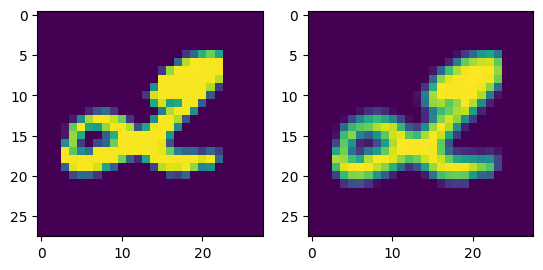

In [68]:
for data,_ in iter(train_loader):
    R, C = 1, 2
    plt.subplot(R, C, 1)
    plt.imshow(data[0].squeeze())
    plt.subplot(R, C, 2)
    plt.imshow(augmentation(data)[0].squeeze())
    
    
    break

## Модель

In [69]:
class TermAverageActivationStatsLayer(torch.nn.Module):
    def __init__(self, terms_count, alpha=1e-2):
        """
        """
        super().__init__()
        #self.dummy = torch.nn.Parameter(torch.empty(0))
        self.terms_count = terms_count
        self.alpha = alpha
        self.accumulated_average_activation = None
        

    def forward(self, x):
        """
        """
        ava = x.mean(0)
        if self.accumulated_average_activation is None:
            self.accumulated_average_activation = ava
        else:
            self.accumulated_average_activation = (1 - self.alpha) * self.accumulated_average_activation + self.alpha * ava

        return x

    def get_norm_stats(self, eps=1e-7):
        """
        
        """
        s = self.accumulated_average_activation.sum() + eps
        return (self.accumulated_average_activation / s).detach()

In [70]:
class TermLatentSpaceCentroidTrackingLayer(torch.nn.Module):
    def __init__(self, latent_dim, alpha=1e-3):
        """
        """
        super().__init__()
        #self.dummy = torch.nn.Parameter(torch.empty(0))
        self.latent_dim = latent_dim
        self.alpha = alpha
        self.aver_centroid = None

    def forward(self, latent_vectors):
        """
        """
        avc = latent_vectors.mean(0)
        if self.aver_centroid is None:
            self.aver_centroid = avc
        else:
            self.aver_centroid = (1 - self.alpha) * self.aver_centroid + self.alpha * avc
        return latent_vectors

    def get_average_centroid(self):
        """
        
        """
        return self.aver_centroid.detach()

In [71]:
class Encoder(nn.Module):
    """
    Компонент энкодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
                
        self.input = nn.Sequential(
            nn.Conv2d(1, kernels, kernel_size=3, padding=2, stride=1),
            nn.BatchNorm2d(kernels, track_running_stats=True),
            nn.SiLU(),  
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(kernels, 2*kernels, kernel_size=6, stride=1, padding = 2),
            nn.BatchNorm2d(2*kernels, track_running_stats=True),
            nn.SiLU(),  
            nn.Conv2d(2*kernels, 2*kernels, kernel_size=6, stride=1, padding = 2),
            nn.BatchNorm2d(2*kernels, track_running_stats=True),
            nn.SiLU(),  
            nn.MaxPool2d(2, stride = 2),
        )

        self.block_3 = nn.Sequential(
            nn.Conv2d(2*kernels, 4*kernels, kernel_size = 6, stride=1, padding = 2),
            nn.BatchNorm2d(4*kernels, track_running_stats=True),
            nn.SiLU(),  
            nn.Conv2d(4*kernels, 4*kernels, kernel_size = 6, stride=1, padding = 2),
            nn.BatchNorm2d(4*kernels, track_running_stats=True),
            nn.SiLU(),  
            nn.MaxPool2d(2, stride = 2),
        )

        self.block_4 = nn.Sequential(
            nn.Conv2d(4*kernels, 8*kernels, kernel_size = 6, stride=1, padding = 2),
            nn.BatchNorm2d(8*kernels, track_running_stats=True),
            nn.SiLU(),  
            nn.Conv2d(8*kernels, 8*kernels, kernel_size = 6, stride=1, padding = 2),
            nn.BatchNorm2d(8*kernels, track_running_stats=True),
            nn.SiLU(),  
            nn.MaxPool2d(2, stride = 2),
        )

        self.out = nn.Sequential(
            nn.AvgPool2d(kernel_size = 1, stride = 1),
            nn.Flatten(),
            nn.Linear(32*kernels, latent_dim)
        )

        self.downscale_1 = nn.Sequential(nn.Conv2d(  kernels, 2*kernels, kernel_size=17))
        self.downscale_2 = nn.Sequential(nn.Conv2d(2*kernels, 4*kernels, kernel_size=9))
        self.downscale_3 = nn.Sequential(nn.Conv2d(4*kernels, 8*kernels, kernel_size=5))
        self.after_sum = nn.SiLU()
        #self.softplus = nn.Softplus()

         
    def forward(self, x, eps: float = 1e-8):
        """
        Выход энкодера для чистого VAE.
        
        Args:
            x (torch.Tensor): Входной вектор.
            eps (float): Небольшая поправка к скейлу для лучшей сходимости и устойчивости.
        
        Returns:
            mu, logvar, z, dist
        """

        x = self.input(x)
        #print(x.shape)
        res_1 = self.downscale_1(x)
        #print(res_1.shape)
        

        x = self.block_2(x)
        #print(x.shape)
        x = self.after_sum(x+res_1)
        res_2 = self.downscale_2(x)
        #print(res_2.shape)
        
        x = self.block_3(x)
        #print(x.shape)
        x = self.after_sum(x+res_2)
        res_3 = self.downscale_3(x)
        #print(res_3.shape)
        
        x = self.block_4(x)
        x = self.after_sum(x+res_3)
        #print(x.shape)

        #x = self.after_sum(x + res_1 + res_2 + res_3) 
        x = self.out(x)
        #print(x.shape)

        return x

In [72]:
inp = torch.rand(10, 1, 28, 28)
m = Encoder(latent_dim)
mu = m.forward(inp)
mu[0].shape

torch.Size([15])

In [73]:
class Decoder(nn.Module):
    """
    Компонент декодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim, fuzzy_rules_count):
        super(Decoder, self).__init__()

        initial_centroids = 1e-5 * (0.5 - np.random.rand(fuzzy_rules_count, latent_dim))
        initial_scales = np.ones((fuzzy_rules_count, latent_dim))       
        self.fuzzy = nn.Sequential(
            TermLatentSpaceCentroidTrackingLayer(latent_dim),
            FuzzyLayer.from_centers_and_scales(initial_centroids, initial_scales, trainable=True),
            TermAverageActivationStatsLayer(fuzzy_rules_count),
            #nn.BatchNorm1d(fuzzy_rules_count, track_running_stats=True),
        )
        
        self.input = nn.Sequential(
            nn.Unflatten(1, (fuzzy_rules_count, 1, 1)),
            nn.BatchNorm2d(fuzzy_rules_count, track_running_stats=True),
            nn.SiLU(),
        )

        self.block_1 = nn.Sequential(
            nn.ConvTranspose2d(fuzzy_rules_count, 16*kernels, 4),
            nn.BatchNorm2d(16*kernels, track_running_stats=True),
            nn.SiLU(), 
            nn.ConvTranspose2d(16*kernels, 16*kernels, 4),
            nn.BatchNorm2d(16*kernels, track_running_stats=True),
            nn.SiLU(), 
        )

        self.block_2 = nn.Sequential(
            nn.ConvTranspose2d(16*kernels, 8*kernels, 4),
            nn.BatchNorm2d(8*kernels, track_running_stats=True),
            nn.SiLU(), 
            nn.ConvTranspose2d(8*kernels, 8*kernels, 4),
            nn.BatchNorm2d(8*kernels, track_running_stats=True),
            nn.SiLU(), 
        )

        self.block_3 = nn.Sequential(
            nn.ConvTranspose2d(8*kernels, 4*kernels, 4),
            nn.BatchNorm2d(4*kernels, track_running_stats=True),
            nn.SiLU(), 
            nn.ConvTranspose2d(4*kernels, 4*kernels, 4),
            nn.BatchNorm2d(4*kernels, track_running_stats=True),
            nn.SiLU(), 
        )

        self.block_4 = nn.Sequential(
            nn.ConvTranspose2d(4*kernels, 2*kernels, 4),
            nn.BatchNorm2d(2*kernels, track_running_stats=True),
            nn.SiLU(), 
            nn.ConvTranspose2d(2*kernels, 2*kernels, 4),
            nn.BatchNorm2d(2*kernels, track_running_stats=True),
            nn.SiLU(), 
        )

        self.block_5 = nn.Sequential(
            nn.ConvTranspose2d(2*kernels, kernels, 2),
            nn.BatchNorm2d(kernels, track_running_stats=True),
            nn.SiLU(), 
            nn.ConvTranspose2d(kernels, kernels, 2),
            nn.BatchNorm2d(kernels, track_running_stats=True),
            nn.SiLU(), 
        )

        self.output = nn.Sequential(
            nn.ConvTranspose2d(kernels, 1, 2),
            nn.Tanh() 
        )
        self.upscale_1 = nn.Sequential(nn.ConvTranspose2d(fuzzy_rules_count, 16*kernels, kernel_size=7))
        self.upscale_2 = nn.Sequential(nn.ConvTranspose2d(16*kernels, 8*kernels, kernel_size=7))
        self.upscale_3 = nn.Sequential(nn.ConvTranspose2d( 8*kernels, 4*kernels, kernel_size=7))
        self.upscale_4 = nn.Sequential(nn.ConvTranspose2d( 4*kernels, 2*kernels, kernel_size=7))
        self.upscale_5 = nn.Sequential(nn.ConvTranspose2d( 2*kernels, kernels,   kernel_size=3))
        self.after_sum = nn.SiLU()
         
    def forward(self, z):
        """
        Декодирует латентный вектор в исходное представление
        
        Args:
            z (torch.Tensor): Латентный вектор.
        
        Returns:
            x
        """
        fz = self.fuzzy(z)
        mapx = self.input(fz)

        x = self.decode_from_mp(mapx)
        return x, fz, mapx
    
    def decode_from_fz(self, fz):
        mapx = self.input(fz)
        x = self.decode_from_mp(mapx)
        return x

    def decode_from_mp(self, x):
        res = self.upscale_1(x)
        #print(res.shape)
        x = self.block_1(x)
        #print(x.shape)
        x = self.after_sum(x+res)

        res = self.upscale_2(x)
        #print(res.shape)
        x = self.block_2(x)
        #print(x.shape)
        x = self.after_sum(x+res)

        res = self.upscale_3(x)
        x = self.block_3(x)
        x = self.after_sum(x+res)

        res = self.upscale_4(x)
        x = self.block_4(x)
        x = self.after_sum(x+res)

        res = self.upscale_5(x)
        x = self.block_5(x)
        x = self.after_sum(x+res)
        
        return self.output(x)

In [74]:
inp = torch.rand(10, latent_dim)
m = Decoder(latent_dim, fuzzy_rules_count=fuzzy_rules_count)
mu, fz, mp = m.forward(inp)
mu.shape

torch.Size([10, 1, 28, 28])

In [75]:
class VAE(nn.Module):
    """
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    def __init__(self, latent_dim, fuzzy_rules_count):
        super(VAE, self).__init__()

        self.encoder = Encoder(latent_dim)        
        self.decoder = Decoder(latent_dim, fuzzy_rules_count)
        self.resd = Decoder(latent_dim, fuzzy_rules_count)
        

    def forward(self, x):
        """
        
        """
        mu = self.encoder(x)
        x_recon, fz, _ = self.decoder(mu)
        x_res, fz_res, _ = self.resd(mu)

        return mu, x_recon, x_res, fz, fz_res
    
    def half_pass(self, x):
        """
        
        """
        mu = self.encoder(x)
        return mu
    
    def decoder_pass(self, x):
        r, f, _ = self.decoder(x)
        return r, f

    def resd_pass(self, x):
        r, f, _ = self.resd(x)
        return r, f

## Обучение

In [76]:
model = VAE(latent_dim=latent_dim, fuzzy_rules_count=fuzzy_rules_count).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

Number of parameters: 252,563


VAE(
  (encoder): Encoder(
    (input): Sequential(
      (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
    )
    (block_2): Sequential(
      (0): Conv2d(2, 4, kernel_size=(6, 6), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
      (3): Conv2d(4, 4, kernel_size=(6, 6), stride=(1, 1), padding=(2, 2))
      (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): SiLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (block_3): Sequential(
      (0): Conv2d(4, 8, kernel_size=(6, 6), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
      (3): Conv2d(8, 8, kernel_size=(6, 6), stride=(1, 1), paddi

In [77]:
#optimizer = torch.optim.Adam(list(model.encoder.parameters()) + list(model.decoder.parameters()), lr=learning_rate)
#optimizer_d = torch.optim.Adam(model.delta_decoder.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

In [78]:
def tarctanh(x):
    return 0.5 * torch.log((1+x)/(1-x))

def log_norm_const(x, eps = 1e-6):
    # numerically stable computation
    x = torch.clamp(x, eps, 1 - eps)
    x = torch.where((x < 0.49) | (x > 0.51), x, 0.49 *
            torch.ones_like(x))
    return torch.log((2 * tarctanh(1 - 2 * x)) /
                    (1 - 2 * x) + eps)

def xent_continuous_ber(recon_x, x, pixelwise=False):
    ''' p(x_i|z_i) a continuous bernoulli '''
    eps = 1e-6
    if pixelwise:
        return (x * torch.log(recon_x + eps) +
                        (1 - x) * torch.log(1 - recon_x + eps) +
                        log_norm_const(recon_x, eps))
    else:
        return torch.mean(torch.sum(x * torch.log(recon_x + eps) +
                        (1 - x) * torch.log(1 - recon_x + eps) +
                        log_norm_const(recon_x, eps), dim=(1, )), dim=(1, 2))
    

a = -torch.ones(3, 1, 28, 28)
b = -torch.ones(3, 1, 28, 28)

xent_continuous_ber((a + 1)/2, (b + 1)/2)

tensor([2.6248, 2.6248, 2.6248])

In [79]:
def compute_vae_loss(x, recon_x):
    
    loss_recon = (x - recon_x).square().sum(-1).sum(-1).mean()
    #loss_recon = -xent_continuous_ber((recon_x + 1)/2, (x + 1)/2)
    #loss_recon = loss_recon.mean()
    
    #raw_loss_recon = (1 - diff).square() #F.binary_cross_entropy((recon_x+1)/2, (x + 1)/2, reduction='none').sum(-1).mean()#
    #loss_recon = raw_loss_recon.mean()
    
    return loss_recon #(x-recon_x).square().sum(-1).sum(-1).mean()
    

In [80]:
def compute_fuzzy_loss(fuzzy, z, fz):
    
    iid = torch.cdist(z, fuzzy.get_centroids()).min(-1).indices.reshape(-1, 1)
    winners = torch.gather(fz, 1, iid).squeeze()
    
    return (1 - winners).clamp(min=0.5).square().mean() + (1 - fz.sum(-1)).square().mean() #(0.999 - (tops[:,0]+tops[:,1]).clamp(max=0.999)).mean() + tops[:, 2].clamp(min=0.001).mean()

In [81]:
def compute_centroids_loss(fuzzy_layer):
    
    c = fuzzy_layer[1].get_centroids()
    c = c.mean(0)
    ac = fuzzy_layer[0].get_average_centroid()

    return (c-ac).square().mean()


In [82]:
eigens = model.decoder.fuzzy[1].get_transformation_matrix_eigenvals().real


In [83]:
def compute_fshape_loss(fuzzy_layer):
    
    eigens = fuzzy_layer.get_transformation_matrix_eigenvals().real
    fz_volume = (0.1 - (eigens.min(-1).values/eigens.max(-1).values).clamp(max=0.1)).square()
    fz_volume = fz_volume.mean()
    
    #fz_scales = (1 - eigens).square().mean()

    return fz_volume
    

In [84]:
def keep_eigenvals_positive_loss(layer, eps = 1e-15):
    ev = layer.get_transformation_matrix_eigenvals().real.min()
    ev = torch.clamp(ev, max=eps)
    return -ev

In [85]:
def get_arate(inp):
    _, x_recon, x_resd, _, _ = model.forward(inp)
    
    # prev_mu = mu
    # sum = torch.zeros_like(mu)
    
    # for i in range(20):
    #     recon_x = model.decoder_pass(mu)
    #     mu, _, _ = model.half_pass(recon_x)
    #     sum += (mu - prev_mu).abs()
    #     prev_mu = mu
    # +
    return (1 - ssim((x_recon + 1)/2, (inp + 1)/2)).cpu().numpy() #ssim((inp + 1)/2, (recon_x+1)/2).cpu().numpy() #fz.sum(-1).cpu().numpy()#

In [86]:
def train(model, dataloader, optimizer, prev_updates, epoch, writer=None):
    model.train()  
    
    for batch_idx, (data, _) in enumerate(tqdm(dataloader, disable=True)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        adata = augmentation(data)
        
        optimizer.zero_grad()  
        z = model.half_pass(adata)  
        x_reconstruct, _ = model.decoder_pass(z)
        x_resd, _ = model.resd_pass(z)
        loss_reconstruct = compute_vae_loss(data, x_reconstruct)
        loss_resd = compute_vae_loss((data - x_reconstruct).abs(), x_resd)
        #fz_loss = compute_fuzzy_loss(model.decoder.fuzzy[1], z, fz)
        #fz_volume = compute_fshape_loss(model.decoder.fuzzy[1])
        
        ev_loss = keep_eigenvals_positive_loss(model.decoder.fuzzy[1])
        if ev_loss.item() > 0:
            ev_loss.backward(retain_graph=True)
        
        #fz_loss.backward(retain_graph=True)
        #fz_volume.backward(retain_graph=True)
        loss_reconstruct.backward(retain_graph=True)
        loss_resd.backward() 
        
        optimizer.step()  

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        
        
    return prev_updates + len(dataloader)

In [87]:
def shannon_entropy(fuzzy):
    distr = fuzzy[2].get_norm_stats()
    dim = distr.shape[0]
    return np.log(dim) + (distr*distr.log()).sum()

In [88]:
fixed_random_z = torch.randn(16, latent_dim).to(device)

def test(model, dataloader, cur_step, epoch, writer=None):
    model.eval() 
    test_recon_loss = 0
    test_kl_loss = 0
    test_fz_loss = 0
    test_fzvol_loss = 0
    test_c_loss = 0
    
    lab_true = []
    lab_pred = []

    with torch.no_grad():
        for data, lab in tqdm(test_loader, desc='Test MNIST', disable=True):
            data = data.view((-1,1,28,28)).to(device)
            rates = get_arate(data)
            
            for f, l in  zip(rates, lab):
                lab_pred.append(f)        
                if l == mnist_class_anomaly:
                    lab_true.append(1)
                else:
                    lab_true.append(0)
                        
    fpr, tpr, _ = metrics.roc_curve(lab_true, lab_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    embedings = []
    labels_expected = []
    centroids = model.decoder.fuzzy[1].get_centroids().detach().cpu().numpy()
    centroids_resd = model.resd.fuzzy[1].get_centroids().detach().cpu().numpy()
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing', disable=True):
            data = data.to(device)
            z = model.half_pass(data)  
            x_reconstruct, fz = model.decoder_pass(z)
            x_resd, _ = model.resd_pass(z)
            
            embedings.append(z.cpu().numpy())
            labels_expected.append(target.cpu().numpy())

            loss_recon = compute_vae_loss(data, x_reconstruct)
            loss_resd = compute_vae_loss((data - x_reconstruct).abs(), x_resd)
            fz_volume = compute_fshape_loss(model.decoder.fuzzy[1])
            c_loss = compute_centroids_loss(model.decoder.fuzzy)    
            fz_loss = compute_fuzzy_loss(model.decoder.fuzzy[1], z, fz)

            test_recon_loss += loss_recon.item()
            test_kl_loss += loss_resd.item()
            test_fz_loss += fz_loss.item()
            test_fzvol_loss += fz_volume.item()
            test_c_loss += c_loss.item()

    embedings = np.concatenate(embedings, axis=0)
    labels_expected = np.concatenate(labels_expected, axis=0)

    if epoch % 5 == 1:
        plt.figure(figsize=(18, 6))

        R, C = 1, 3

        plt.subplot(R, C, 1)
        plt.title("MNIST XY")
        plt.scatter(embedings[:, 0],      embedings[:,  1], c=labels_expected, cmap='tab10', s=2)
        plt.scatter(centroids[:, 0],      centroids[:, 1], marker='1', c='black', s= 50)
        plt.scatter(centroids_resd[:, 0],      centroids_resd[:, 1], marker='2', c='red', s= 20)
        
        # plt.xlim((-1, 1))
        # plt.ylim((-1, 1))

        plt.subplot(R, C, 2)
        plt.title("MNIST XZ")
        plt.scatter(embedings[:, 0],      embedings[:,  2], c=labels_expected, cmap='tab10', s=2)
        plt.scatter(centroids[:, 0],      centroids[:, 2], marker='1', c='black', s= 50)
        plt.scatter(centroids_resd[:, 0], centroids_resd[:, 2], marker='2', c='red', s= 20)
        
        # plt.xlim((-1, 1))
        # plt.ylim((-1, 1))

        plt.show()
    
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    test_fz_loss /= len(dataloader)
    test_fzvol_loss /= len(dataloader)
    test_c_loss /= len(dataloader)
    print(f'[{cur_step}] Reconstruction loss: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f} AUC {roc_auc:.4f} FZ {test_fz_loss:.4f} FZVOL {test_fzvol_loss:.4f} CENTROIDS DISCREPANCY {test_c_loss:.4f} SHANNON {shannon_entropy(model.decoder.fuzzy)}')
    #print(f'Average activation stats: {model.decoder.fuzzy[2].get_norm_stats()}')
    #print(f'Average centroid stats: {model.decoder.fuzzy[0].get_average_centroid()}')
    if writer is not None:
        writer.add_histogram('ADFVAE/TermActivation', model.decoder.fuzzy[2].get_norm_stats(), cur_step)
        writer.add_scalar('ADFVAE/AUC', roc_auc, global_step=cur_step)
        writer.add_scalar('ADFVAE/Reconstruction', test_recon_loss, global_step=cur_step)
        writer.add_scalar('ADFVAE/KLD', test_kl_loss, global_step=cur_step)
        writer.add_scalar('ADFVAE/Fuzzy', test_fz_loss, global_step=cur_step)
        writer.add_scalar('ADFVAE/Fuzzy/Vol', test_fzvol_loss, global_step=cur_step)
        writer.add_scalar('ADFVAE/Fuzzy/CDist', test_c_loss, global_step=cur_step)
        
        samples, _ = model.decoder_pass(fixed_random_z)
        samples_resd, _ = model.resd_pass(fixed_random_z)
        writer.add_images('ADFVAE/Samples', samples.view(-1, 1, 28, 28), global_step=cur_step)
        writer.add_images('ADFVAE/ResdSamples', samples_resd.view(-1, 1, 28, 28), global_step=cur_step)

In [89]:
prev_updates = 0

[212] Reconstruction loss: 186.3091, KLD: 33.6063 AUC 0.7341 FZ 140.4803 FZVOL 0.0000 CENTROIDS DISCREPANCY 0.1397 SHANNON 0.00035691261291503906


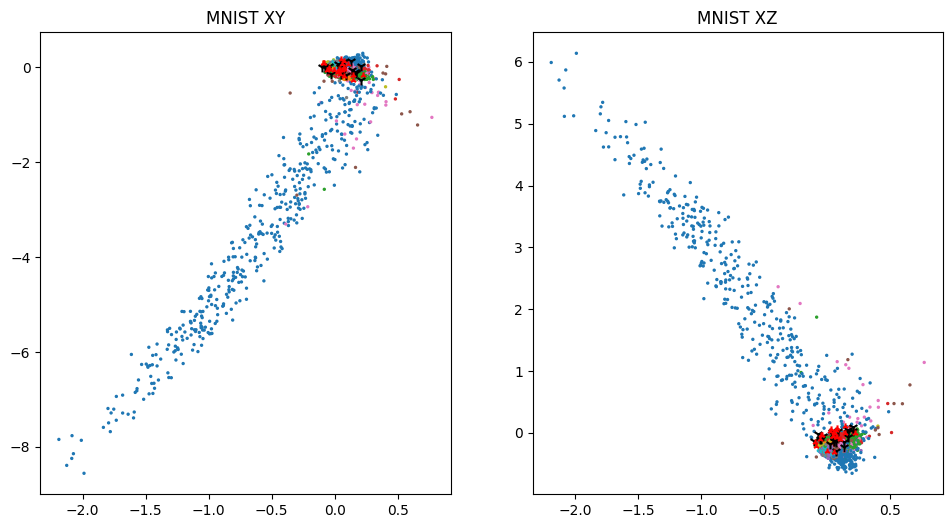

[424] Reconstruction loss: 147.6737, KLD: 31.5761 AUC 0.7294 FZ 76.7980 FZVOL 0.0000 CENTROIDS DISCREPANCY 0.0921 SHANNON 0.002030611038208008
[636] Reconstruction loss: 104.7822, KLD: 27.9292 AUC 0.7867 FZ 50.6031 FZVOL 0.0000 CENTROIDS DISCREPANCY 0.0544 SHANNON 0.005960702896118164
[848] Reconstruction loss: 91.5679, KLD: 28.3531 AUC 0.8322 FZ 46.6766 FZVOL 0.0000 CENTROIDS DISCREPANCY 0.0322 SHANNON 0.005624294281005859
[1060] Reconstruction loss: 83.7951, KLD: 26.5248 AUC 0.8799 FZ 38.1229 FZVOL 0.0000 CENTROIDS DISCREPANCY 0.0203 SHANNON 0.005973100662231445
[1272] Reconstruction loss: 70.3513, KLD: 22.8500 AUC 0.8703 FZ 37.0814 FZVOL 0.0001 CENTROIDS DISCREPANCY 0.0149 SHANNON 0.005821943283081055


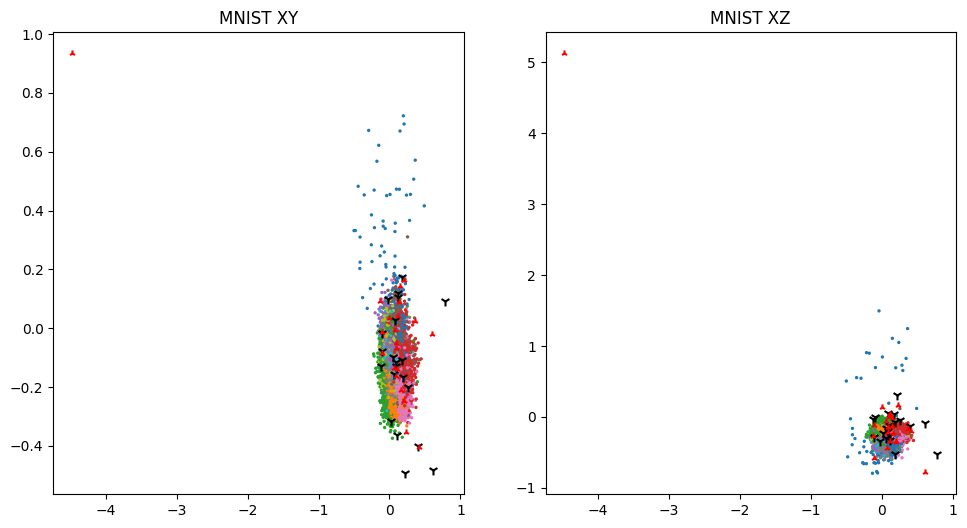

[1484] Reconstruction loss: 70.7922, KLD: 25.5698 AUC 0.8613 FZ 37.2368 FZVOL 0.0002 CENTROIDS DISCREPANCY 0.0131 SHANNON 0.006112337112426758
[1696] Reconstruction loss: 64.6374, KLD: 23.3051 AUC 0.9055 FZ 33.6681 FZVOL 0.0005 CENTROIDS DISCREPANCY 0.0138 SHANNON 0.004896402359008789
[1908] Reconstruction loss: 62.0016, KLD: 22.4678 AUC 0.9091 FZ 31.6394 FZVOL 0.0010 CENTROIDS DISCREPANCY 0.0184 SHANNON 0.0047833919525146484
[2120] Reconstruction loss: 96.9733, KLD: 37.0107 AUC 0.8413 FZ 24.1950 FZVOL 0.0013 CENTROIDS DISCREPANCY 0.0217 SHANNON 0.004644632339477539
[2332] Reconstruction loss: 54.0289, KLD: 19.6660 AUC 0.9215 FZ 23.7329 FZVOL 0.0019 CENTROIDS DISCREPANCY 0.0433 SHANNON 0.005475282669067383


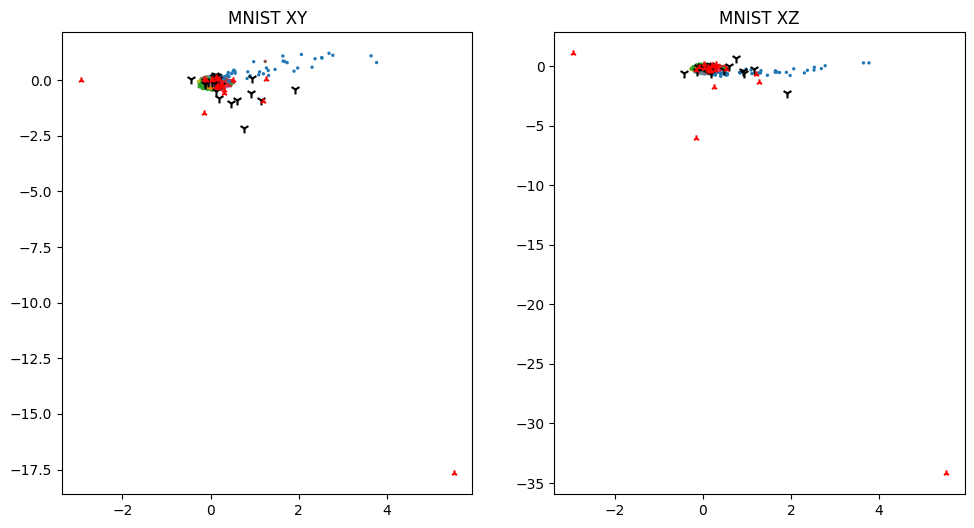

[2544] Reconstruction loss: 54.5351, KLD: 20.8411 AUC 0.9285 FZ 22.2398 FZVOL 0.0023 CENTROIDS DISCREPANCY 0.0701 SHANNON 0.005113840103149414
[2756] Reconstruction loss: 56.1458, KLD: 22.1702 AUC 0.9465 FZ 22.0668 FZVOL 0.0026 CENTROIDS DISCREPANCY 0.0767 SHANNON 0.00512242317199707
[2968] Reconstruction loss: 56.8462, KLD: 23.2990 AUC 0.9468 FZ 20.1363 FZVOL 0.0031 CENTROIDS DISCREPANCY 0.4286 SHANNON 0.0049626827239990234
[3180] Reconstruction loss: 55.8418, KLD: 23.1899 AUC 0.9445 FZ 18.7503 FZVOL 0.0032 CENTROIDS DISCREPANCY 0.6533 SHANNON 0.005296468734741211
[3392] Reconstruction loss: 54.4927, KLD: 21.9423 AUC 0.9495 FZ 17.6812 FZVOL 0.0035 CENTROIDS DISCREPANCY 1.2739 SHANNON 0.0054819583892822266


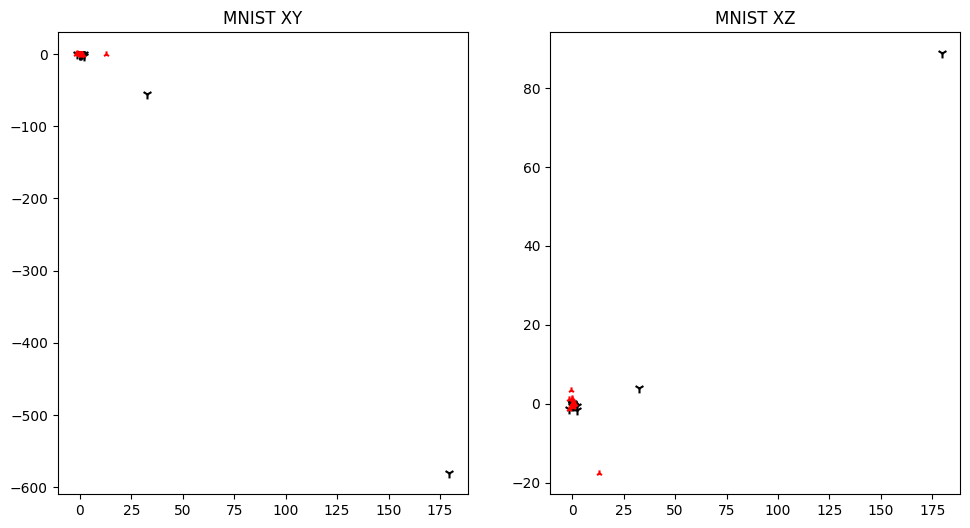

[3604] Reconstruction loss: 52.7376, KLD: 21.1688 AUC 0.9604 FZ 16.1512 FZVOL 0.0037 CENTROIDS DISCREPANCY 237.4538 SHANNON 0.0055332183837890625
[3816] Reconstruction loss: 55.2563, KLD: 22.5869 AUC 0.9335 FZ 15.5950 FZVOL 0.0040 CENTROIDS DISCREPANCY 74.9979 SHANNON 0.005959272384643555
[4028] Reconstruction loss: 54.5201, KLD: 22.2530 AUC 0.9490 FZ 15.2769 FZVOL 0.0042 CENTROIDS DISCREPANCY 1.4793 SHANNON 0.006086826324462891
[4240] Reconstruction loss: 66.4013, KLD: 29.9717 AUC 0.9682 FZ 14.4910 FZVOL 0.0044 CENTROIDS DISCREPANCY 0.6503 SHANNON 0.006688833236694336
[4452] Reconstruction loss: 69.2448, KLD: 32.4746 AUC 0.9433 FZ 13.8126 FZVOL 0.0047 CENTROIDS DISCREPANCY 2.2313 SHANNON 0.0066564083099365234


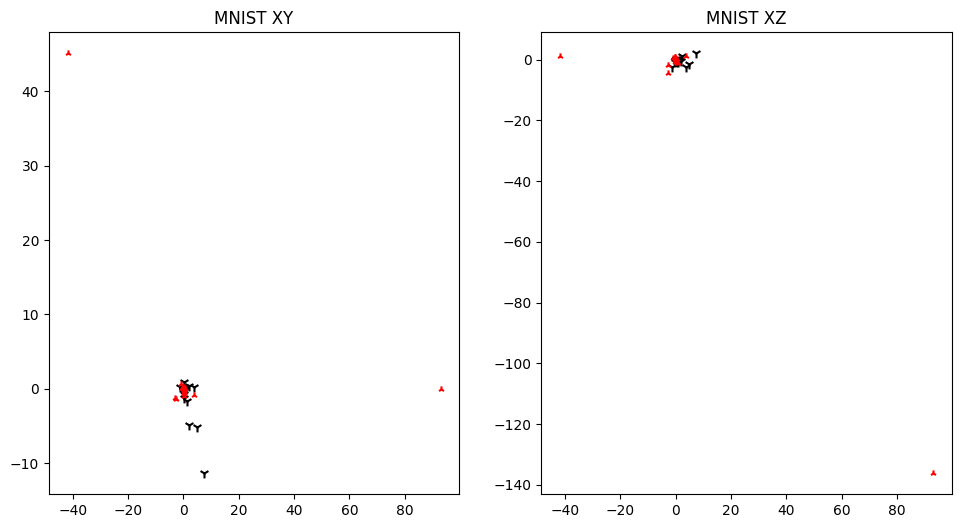

[4664] Reconstruction loss: 51.9646, KLD: 21.8161 AUC 0.9637 FZ 12.4240 FZVOL 0.0049 CENTROIDS DISCREPANCY 0.6978 SHANNON 0.006814241409301758
[4876] Reconstruction loss: 44.4457, KLD: 17.9653 AUC 0.9550 FZ 11.9227 FZVOL 0.0052 CENTROIDS DISCREPANCY 1.1745 SHANNON 0.007128000259399414
[5088] Reconstruction loss: 66.7937, KLD: 31.8052 AUC 0.9498 FZ 11.4054 FZVOL 0.0055 CENTROIDS DISCREPANCY 6.7265 SHANNON 0.007601022720336914
[5300] Reconstruction loss: 55.7473, KLD: 24.8266 AUC 0.9389 FZ 10.9181 FZVOL 0.0057 CENTROIDS DISCREPANCY 1.9075 SHANNON 0.0076487064361572266
[5512] Reconstruction loss: 50.7429, KLD: 20.8203 AUC 0.9571 FZ 10.2442 FZVOL 0.0057 CENTROIDS DISCREPANCY 1.2318 SHANNON 0.0075223445892333984


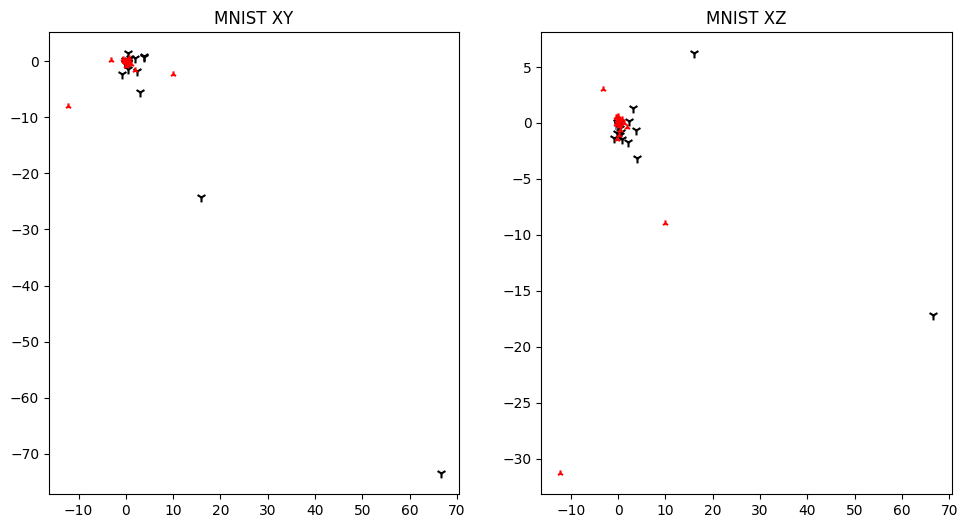

[5724] Reconstruction loss: 48.2935, KLD: 20.3286 AUC 0.9131 FZ 10.1280 FZVOL 0.0060 CENTROIDS DISCREPANCY 7.4100 SHANNON 0.007714509963989258
[5936] Reconstruction loss: 48.4715, KLD: 19.9747 AUC 0.9446 FZ 9.4742 FZVOL 0.0061 CENTROIDS DISCREPANCY 1.3864 SHANNON 0.00847768783569336
[6148] Reconstruction loss: 54.2686, KLD: 24.8295 AUC 0.9495 FZ 9.1542 FZVOL 0.0063 CENTROIDS DISCREPANCY 1.9474 SHANNON 0.009053468704223633
[6360] Reconstruction loss: 44.7826, KLD: 18.9478 AUC 0.9603 FZ 8.7482 FZVOL 0.0064 CENTROIDS DISCREPANCY 10.6945 SHANNON 0.008974313735961914
[6572] Reconstruction loss: 52.4502, KLD: 21.7220 AUC 0.9191 FZ 8.1512 FZVOL 0.0064 CENTROIDS DISCREPANCY 31.1423 SHANNON 0.009024381637573242


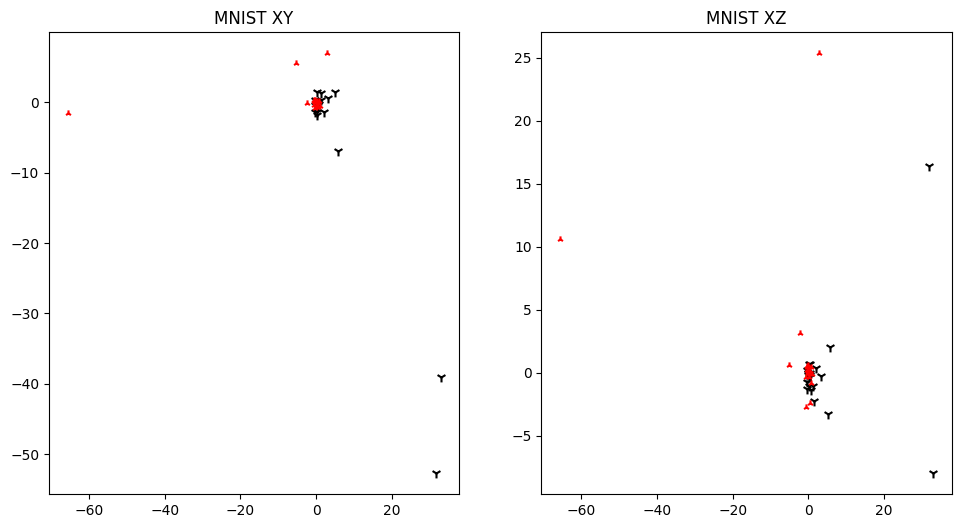

[6784] Reconstruction loss: 52.8469, KLD: 22.4432 AUC 0.9506 FZ 7.9225 FZVOL 0.0067 CENTROIDS DISCREPANCY 8.5500 SHANNON 0.009443283081054688
[6996] Reconstruction loss: 47.4329, KLD: 20.6633 AUC 0.9299 FZ 7.6087 FZVOL 0.0066 CENTROIDS DISCREPANCY 2.8898 SHANNON 0.009421110153198242
[7208] Reconstruction loss: 50.2371, KLD: 22.0128 AUC 0.9409 FZ 7.0983 FZVOL 0.0069 CENTROIDS DISCREPANCY 1.5087 SHANNON 0.010408878326416016
[7420] Reconstruction loss: 55.8146, KLD: 24.7004 AUC 0.9053 FZ 6.8169 FZVOL 0.0071 CENTROIDS DISCREPANCY 2.6062 SHANNON 0.010883569717407227
[7632] Reconstruction loss: 44.3954, KLD: 17.7907 AUC 0.9464 FZ 6.4122 FZVOL 0.0073 CENTROIDS DISCREPANCY 4.0041 SHANNON 0.011414766311645508


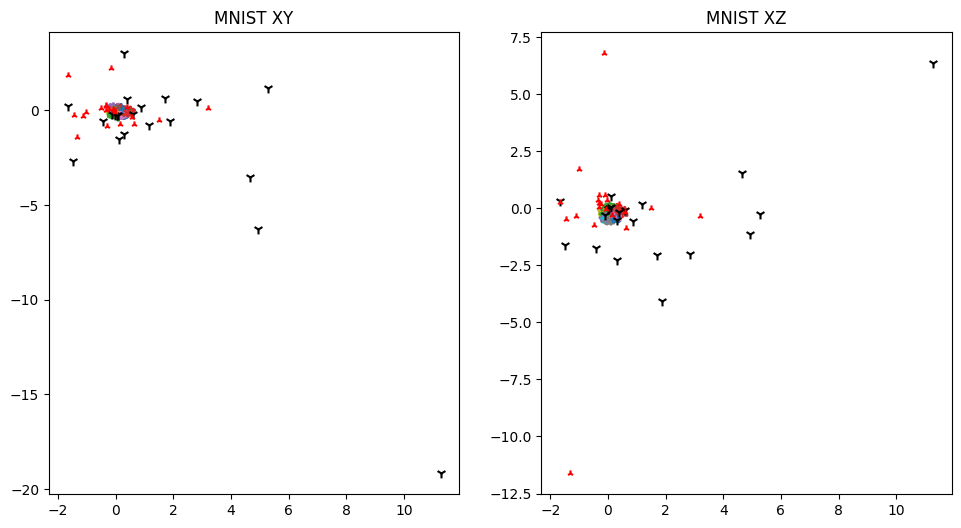

[7844] Reconstruction loss: 44.6956, KLD: 19.1366 AUC 0.9482 FZ 6.1334 FZVOL 0.0072 CENTROIDS DISCREPANCY 1.5030 SHANNON 0.011815786361694336
[8056] Reconstruction loss: 50.1868, KLD: 21.4133 AUC 0.9272 FZ 5.9020 FZVOL 0.0074 CENTROIDS DISCREPANCY 20.6608 SHANNON 0.012274026870727539
[8268] Reconstruction loss: 58.7578, KLD: 26.8445 AUC 0.9429 FZ 5.7159 FZVOL 0.0076 CENTROIDS DISCREPANCY 3.1688 SHANNON 0.012381315231323242
[8480] Reconstruction loss: 50.0382, KLD: 21.4315 AUC 0.9466 FZ 5.5088 FZVOL 0.0076 CENTROIDS DISCREPANCY 7.9077 SHANNON 0.0127716064453125
[8692] Reconstruction loss: 54.6343, KLD: 24.3385 AUC 0.9073 FZ 5.1366 FZVOL 0.0074 CENTROIDS DISCREPANCY 0.9526 SHANNON 0.013599634170532227


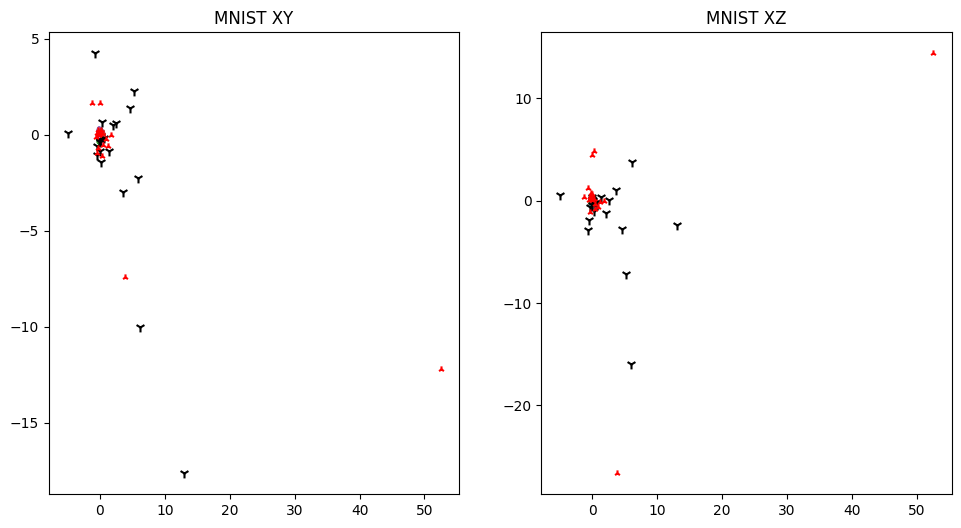

[8904] Reconstruction loss: 43.5632, KLD: 18.2127 AUC 0.9542 FZ 4.8954 FZVOL 0.0076 CENTROIDS DISCREPANCY 2.7490 SHANNON 0.013613224029541016
[9116] Reconstruction loss: 48.9474, KLD: 21.1508 AUC 0.9281 FZ 4.5387 FZVOL 0.0076 CENTROIDS DISCREPANCY 1.9655 SHANNON 0.014161109924316406
[9328] Reconstruction loss: 40.2875, KLD: 15.9034 AUC 0.9410 FZ 4.1421 FZVOL 0.0076 CENTROIDS DISCREPANCY 4.9459 SHANNON 0.015393972396850586
[9540] Reconstruction loss: 55.4603, KLD: 23.8228 AUC 0.9599 FZ 3.9561 FZVOL 0.0077 CENTROIDS DISCREPANCY 2.3215 SHANNON 0.01581883430480957
[9752] Reconstruction loss: 50.9567, KLD: 22.2831 AUC 0.9367 FZ 3.8027 FZVOL 0.0076 CENTROIDS DISCREPANCY 1.7404 SHANNON 0.016636133193969727


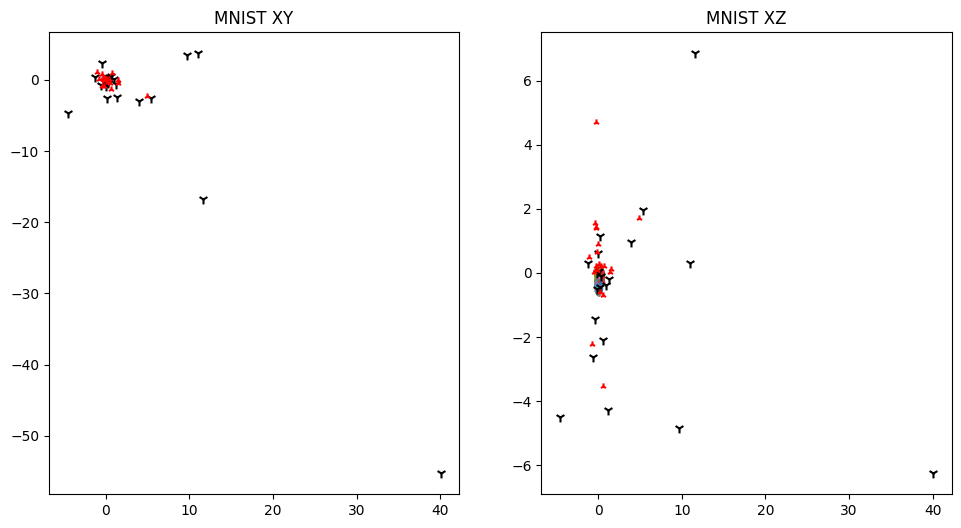

[9964] Reconstruction loss: 42.3491, KLD: 17.4797 AUC 0.9497 FZ 3.4900 FZVOL 0.0079 CENTROIDS DISCREPANCY 6.2878 SHANNON 0.017657756805419922
[10176] Reconstruction loss: 38.4671, KLD: 15.6640 AUC 0.9478 FZ 3.4470 FZVOL 0.0078 CENTROIDS DISCREPANCY 2.0723 SHANNON 0.017939329147338867
[10388] Reconstruction loss: 70.8704, KLD: 34.1144 AUC 0.9216 FZ 3.2475 FZVOL 0.0079 CENTROIDS DISCREPANCY 1.9133 SHANNON 0.01925206184387207
[10600] Reconstruction loss: 42.6575, KLD: 18.6890 AUC 0.9256 FZ 2.9005 FZVOL 0.0079 CENTROIDS DISCREPANCY 2.4124 SHANNON 0.02091503143310547
[10812] Reconstruction loss: 47.6438, KLD: 21.3302 AUC 0.9395 FZ 2.9335 FZVOL 0.0082 CENTROIDS DISCREPANCY 5.3676 SHANNON 0.0210573673248291


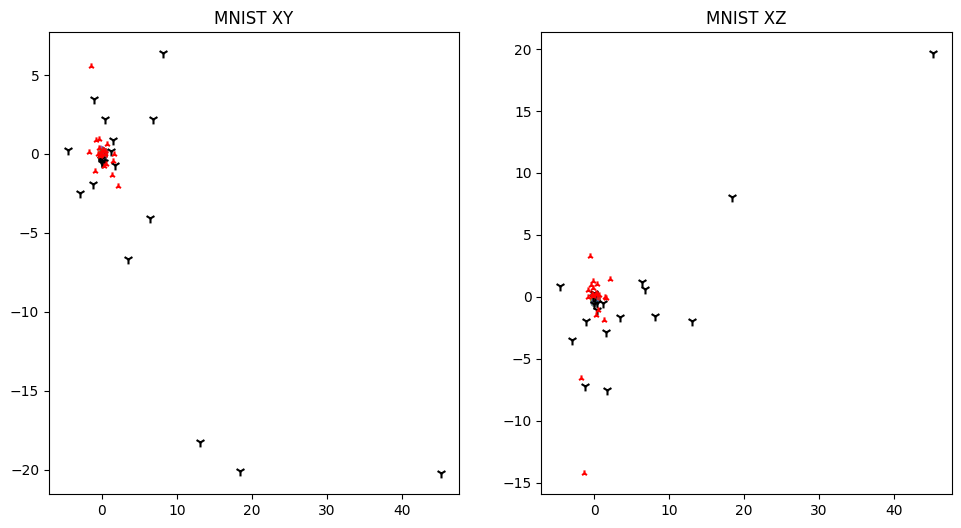

[11024] Reconstruction loss: 45.4848, KLD: 19.1991 AUC 0.9569 FZ 2.7665 FZVOL 0.0082 CENTROIDS DISCREPANCY 8.5277 SHANNON 0.02101278305053711
[11236] Reconstruction loss: 49.3516, KLD: 21.4480 AUC 0.9401 FZ 2.6873 FZVOL 0.0082 CENTROIDS DISCREPANCY 3.4796 SHANNON 0.021935224533081055
[11448] Reconstruction loss: 40.1834, KLD: 16.5713 AUC 0.9390 FZ 2.6541 FZVOL 0.0083 CENTROIDS DISCREPANCY 14.8737 SHANNON 0.022510766983032227
[11660] Reconstruction loss: 37.8117, KLD: 15.1628 AUC 0.9412 FZ 2.5529 FZVOL 0.0085 CENTROIDS DISCREPANCY 7050.8655 SHANNON 0.02300429344177246
[11872] Reconstruction loss: 44.6637, KLD: 18.8069 AUC 0.9523 FZ 2.4376 FZVOL 0.0083 CENTROIDS DISCREPANCY 5.4804 SHANNON 0.024099349975585938


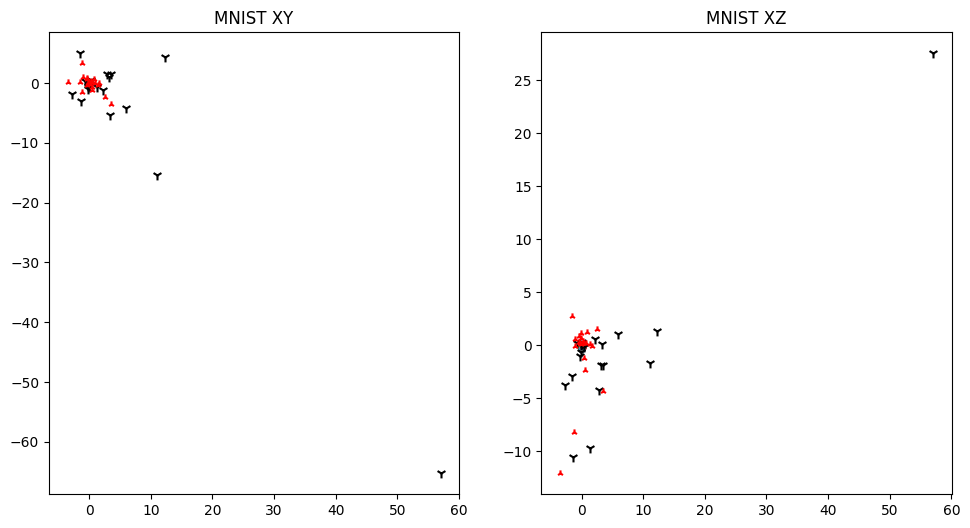

[12084] Reconstruction loss: 45.9130, KLD: 20.3412 AUC 0.9073 FZ 2.4174 FZVOL 0.0083 CENTROIDS DISCREPANCY 11.2833 SHANNON 0.025023937225341797
[12296] Reconstruction loss: 38.4604, KLD: 15.7357 AUC 0.9458 FZ 2.3061 FZVOL 0.0084 CENTROIDS DISCREPANCY 8.0998 SHANNON 0.02601766586303711
[12508] Reconstruction loss: 36.1507, KLD: 14.6363 AUC 0.9437 FZ 2.1494 FZVOL 0.0084 CENTROIDS DISCREPANCY 10.0118 SHANNON 0.02698230743408203
[12720] Reconstruction loss: 38.4765, KLD: 16.3911 AUC 0.9441 FZ 2.0609 FZVOL 0.0083 CENTROIDS DISCREPANCY 56.9512 SHANNON 0.027987241744995117
[12932] Reconstruction loss: 40.7367, KLD: 16.6548 AUC 0.9570 FZ 1.9872 FZVOL 0.0084 CENTROIDS DISCREPANCY 7.1380 SHANNON 0.02815556526184082


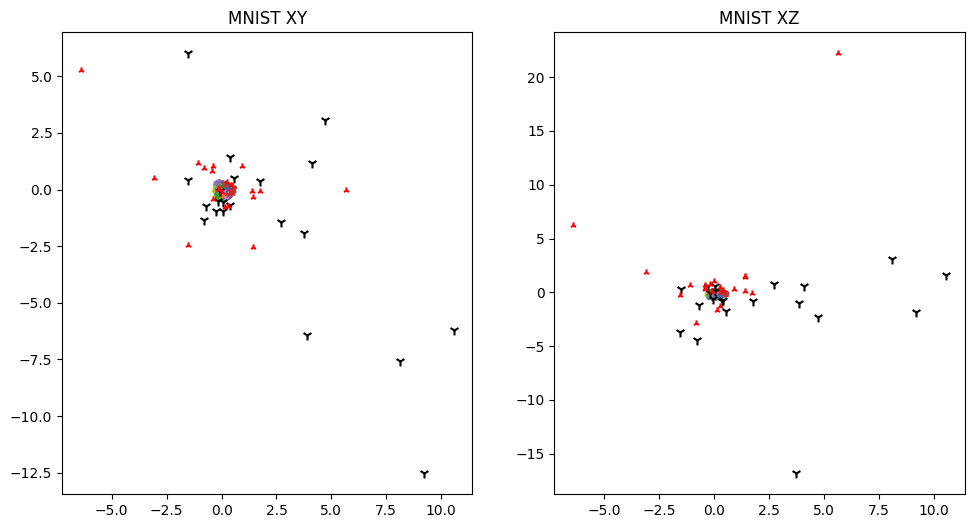

[13144] Reconstruction loss: 37.8800, KLD: 15.3028 AUC 0.9444 FZ 1.8701 FZVOL 0.0084 CENTROIDS DISCREPANCY 2.3433 SHANNON 0.029532909393310547
[13356] Reconstruction loss: 44.3424, KLD: 19.7668 AUC 0.9549 FZ 1.8131 FZVOL 0.0084 CENTROIDS DISCREPANCY 2.7181 SHANNON 0.030466794967651367
[13568] Reconstruction loss: 36.2089, KLD: 14.4623 AUC 0.9538 FZ 1.7315 FZVOL 0.0086 CENTROIDS DISCREPANCY 4.7031 SHANNON 0.031563758850097656
[13780] Reconstruction loss: 38.4991, KLD: 15.9680 AUC 0.9429 FZ 1.6431 FZVOL 0.0087 CENTROIDS DISCREPANCY 12.5417 SHANNON 0.03241610527038574
[13992] Reconstruction loss: 44.0825, KLD: 19.1368 AUC 0.9198 FZ 1.5835 FZVOL 0.0088 CENTROIDS DISCREPANCY 9.4679 SHANNON 0.03451275825500488


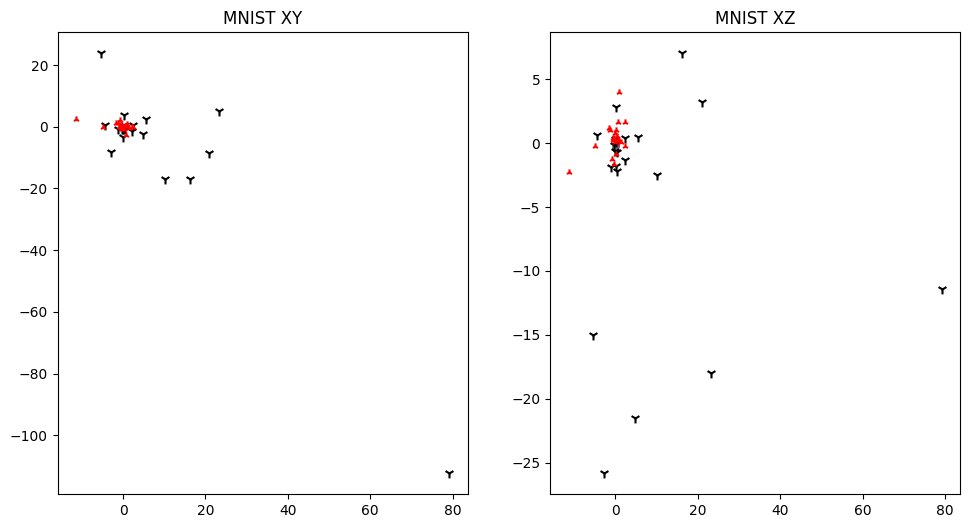

[14204] Reconstruction loss: 46.2032, KLD: 20.0770 AUC 0.9627 FZ 1.5051 FZVOL 0.0088 CENTROIDS DISCREPANCY 25.6570 SHANNON 0.03542637825012207
[14416] Reconstruction loss: 43.5475, KLD: 18.9460 AUC 0.9272 FZ 1.4098 FZVOL 0.0084 CENTROIDS DISCREPANCY 8.1766 SHANNON 0.03701519966125488
[14628] Reconstruction loss: 44.0082, KLD: 20.0535 AUC 0.9553 FZ 1.3808 FZVOL 0.0085 CENTROIDS DISCREPANCY 18.7228 SHANNON 0.03837943077087402
[14840] Reconstruction loss: 40.3907, KLD: 16.9020 AUC 0.9141 FZ 1.2851 FZVOL 0.0085 CENTROIDS DISCREPANCY 6.8778 SHANNON 0.040145158767700195
[15052] Reconstruction loss: 40.9671, KLD: 17.2310 AUC 0.9432 FZ 1.2350 FZVOL 0.0086 CENTROIDS DISCREPANCY 4.1419 SHANNON 0.041689157485961914


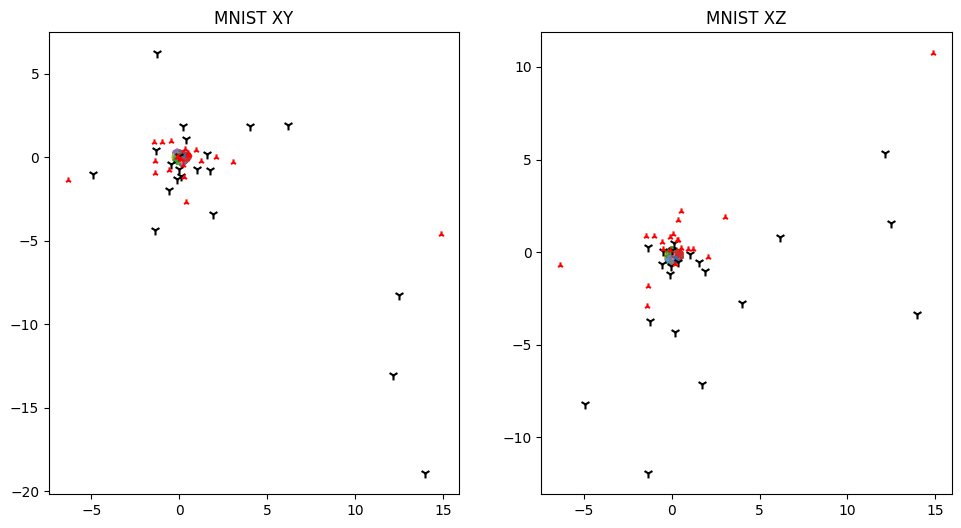

[15264] Reconstruction loss: 41.6900, KLD: 18.0266 AUC 0.9427 FZ 1.1748 FZVOL 0.0087 CENTROIDS DISCREPANCY 3.4124 SHANNON 0.043776750564575195
[15476] Reconstruction loss: 48.5562, KLD: 22.2515 AUC 0.9472 FZ 1.1217 FZVOL 0.0088 CENTROIDS DISCREPANCY 62.2114 SHANNON 0.04658627510070801
[15688] Reconstruction loss: 51.7619, KLD: 25.0616 AUC 0.9318 FZ 1.0870 FZVOL 0.0088 CENTROIDS DISCREPANCY 5.7343 SHANNON 0.04834747314453125
[15900] Reconstruction loss: 43.7183, KLD: 18.9307 AUC 0.9336 FZ 1.0407 FZVOL 0.0087 CENTROIDS DISCREPANCY 11.5505 SHANNON 0.05016016960144043
[16112] Reconstruction loss: 44.7179, KLD: 19.5763 AUC 0.9256 FZ 1.0165 FZVOL 0.0086 CENTROIDS DISCREPANCY 3.8452 SHANNON 0.05166172981262207


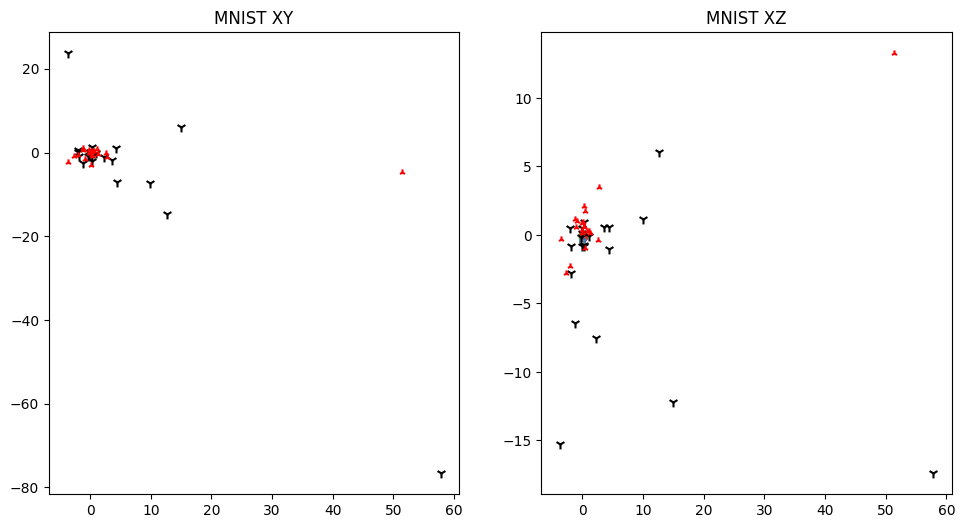

[16324] Reconstruction loss: 45.7763, KLD: 19.8547 AUC 0.9323 FZ 0.9813 FZVOL 0.0087 CENTROIDS DISCREPANCY 12.7406 SHANNON 0.0545039176940918
[16536] Reconstruction loss: 43.7047, KLD: 19.3662 AUC 0.9398 FZ 0.9641 FZVOL 0.0088 CENTROIDS DISCREPANCY 21.0742 SHANNON 0.0569608211517334
[16748] Reconstruction loss: 44.6918, KLD: 19.2299 AUC 0.9503 FZ 0.9419 FZVOL 0.0089 CENTROIDS DISCREPANCY 15.8250 SHANNON 0.059328317642211914
[16960] Reconstruction loss: 53.5458, KLD: 26.1266 AUC 0.9206 FZ 0.9288 FZVOL 0.0089 CENTROIDS DISCREPANCY 18.1310 SHANNON 0.06067395210266113
[17172] Reconstruction loss: 38.0500, KLD: 15.6279 AUC 0.9492 FZ 0.9177 FZVOL 0.0089 CENTROIDS DISCREPANCY 5.1480 SHANNON 0.06231069564819336


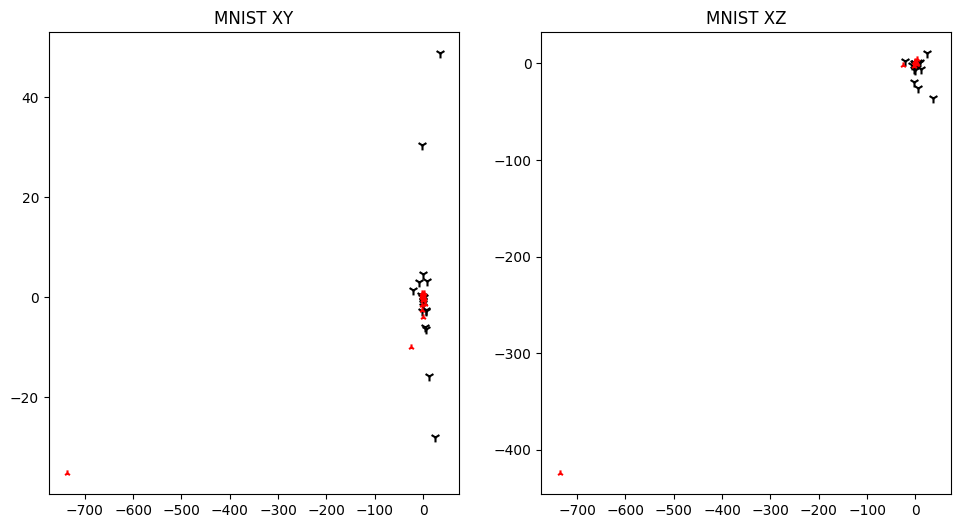

[17384] Reconstruction loss: 41.9617, KLD: 17.2451 AUC 0.9497 FZ 0.9163 FZVOL 0.0090 CENTROIDS DISCREPANCY 21.8478 SHANNON 0.06324291229248047
[17596] Reconstruction loss: 38.6134, KLD: 15.7150 AUC 0.9550 FZ 0.9036 FZVOL 0.0089 CENTROIDS DISCREPANCY 294.0967 SHANNON 0.06522107124328613
[17808] Reconstruction loss: 39.2540, KLD: 16.2474 AUC 0.9301 FZ 0.9124 FZVOL 0.0090 CENTROIDS DISCREPANCY 5.6456 SHANNON 0.06771731376647949
[18020] Reconstruction loss: 39.8534, KLD: 16.5942 AUC 0.9440 FZ 0.9133 FZVOL 0.0089 CENTROIDS DISCREPANCY 48.9756 SHANNON 0.0690457820892334
[18232] Reconstruction loss: 39.9578, KLD: 17.0715 AUC 0.9487 FZ 0.9252 FZVOL 0.0086 CENTROIDS DISCREPANCY 2.4744 SHANNON 0.06938004493713379


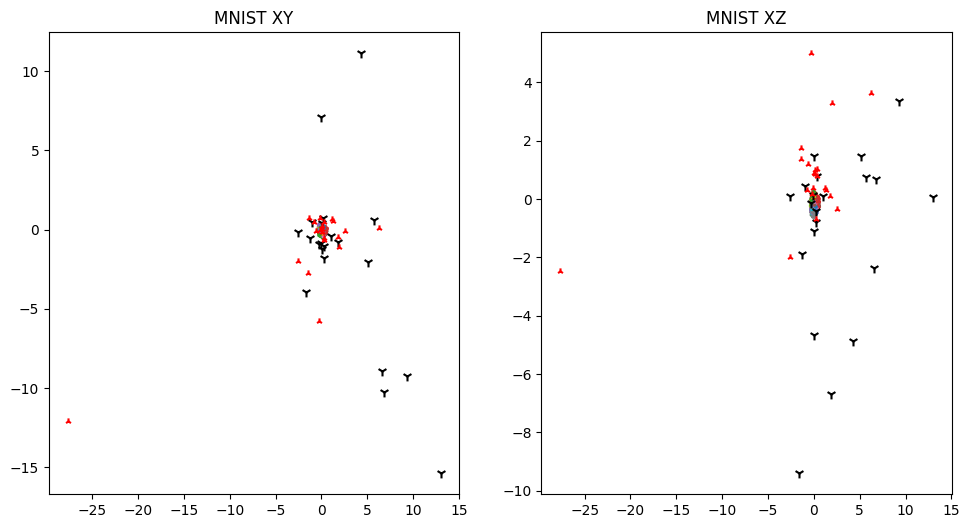

[18444] Reconstruction loss: 50.6963, KLD: 23.7513 AUC 0.9193 FZ 0.9261 FZVOL 0.0087 CENTROIDS DISCREPANCY 2.1950 SHANNON 0.07117772102355957
[18656] Reconstruction loss: 43.8430, KLD: 19.7904 AUC 0.9474 FZ 0.9294 FZVOL 0.0088 CENTROIDS DISCREPANCY 4.5060 SHANNON 0.0721433162689209
[18868] Reconstruction loss: 43.0907, KLD: 19.1295 AUC 0.9244 FZ 0.9322 FZVOL 0.0089 CENTROIDS DISCREPANCY 10.0108 SHANNON 0.07233452796936035
[19080] Reconstruction loss: 43.5674, KLD: 19.6959 AUC 0.9343 FZ 0.9455 FZVOL 0.0089 CENTROIDS DISCREPANCY 16.3382 SHANNON 0.07281374931335449
[19292] Reconstruction loss: 41.1069, KLD: 17.5064 AUC 0.9383 FZ 0.9437 FZVOL 0.0089 CENTROIDS DISCREPANCY 3.7545 SHANNON 0.0743257999420166


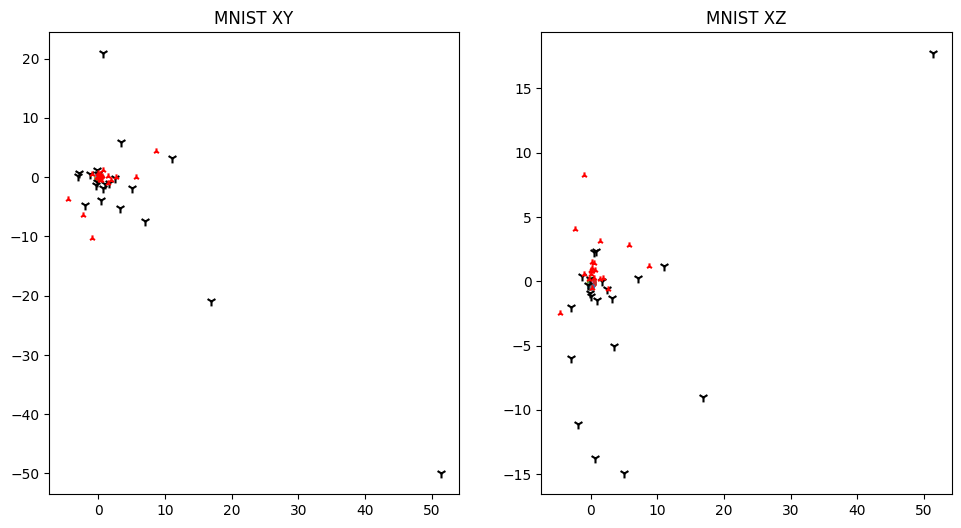

[19504] Reconstruction loss: 55.3979, KLD: 27.5043 AUC 0.9325 FZ 0.9496 FZVOL 0.0090 CENTROIDS DISCREPANCY 15.8970 SHANNON 0.07270979881286621
[19716] Reconstruction loss: 34.3906, KLD: 13.5754 AUC 0.9387 FZ 0.9586 FZVOL 0.0090 CENTROIDS DISCREPANCY 8.8596 SHANNON 0.07431435585021973
[19928] Reconstruction loss: 53.4185, KLD: 25.4243 AUC 0.9251 FZ 0.9659 FZVOL 0.0089 CENTROIDS DISCREPANCY 4.1803 SHANNON 0.07443952560424805
[20140] Reconstruction loss: 40.4748, KLD: 17.7578 AUC 0.9474 FZ 0.9819 FZVOL 0.0090 CENTROIDS DISCREPANCY 19.6392 SHANNON 0.07518601417541504
[20352] Reconstruction loss: 39.7439, KLD: 17.5596 AUC 0.9168 FZ 0.9905 FZVOL 0.0090 CENTROIDS DISCREPANCY 8.2693 SHANNON 0.07536721229553223


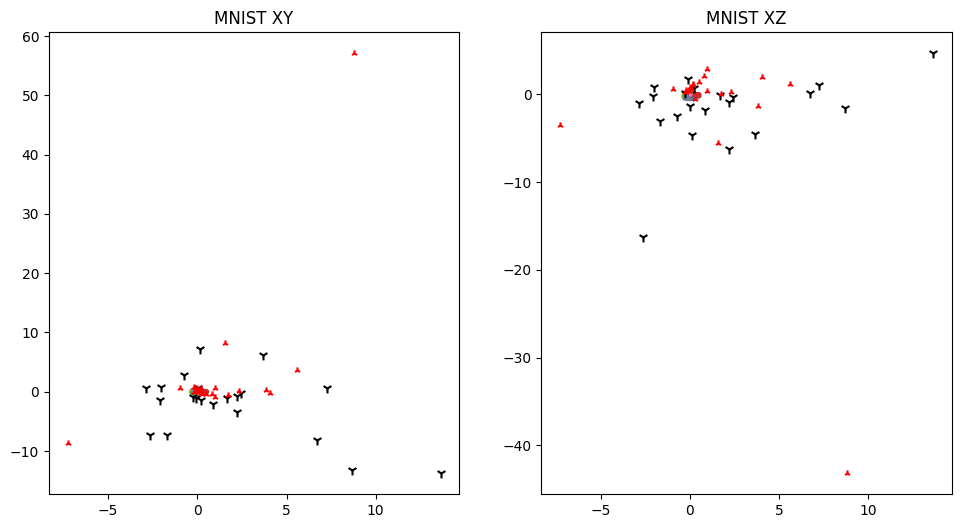

[20564] Reconstruction loss: 49.0105, KLD: 22.9920 AUC 0.8909 FZ 0.9986 FZVOL 0.0090 CENTROIDS DISCREPANCY 3.0513 SHANNON 0.07532715797424316
[20776] Reconstruction loss: 54.0948, KLD: 26.6289 AUC 0.9494 FZ 1.0144 FZVOL 0.0091 CENTROIDS DISCREPANCY 6.9177 SHANNON 0.07555317878723145
[20988] Reconstruction loss: 40.7159, KLD: 16.6110 AUC 0.9463 FZ 1.0260 FZVOL 0.0090 CENTROIDS DISCREPANCY 11.3520 SHANNON 0.07456755638122559
[21200] Reconstruction loss: 42.6810, KLD: 18.9793 AUC 0.9437 FZ 1.0353 FZVOL 0.0091 CENTROIDS DISCREPANCY 88.0954 SHANNON 0.07378864288330078
[21412] Reconstruction loss: 35.9501, KLD: 14.9304 AUC 0.9344 FZ 1.0455 FZVOL 0.0091 CENTROIDS DISCREPANCY 13.4697 SHANNON 0.07482457160949707


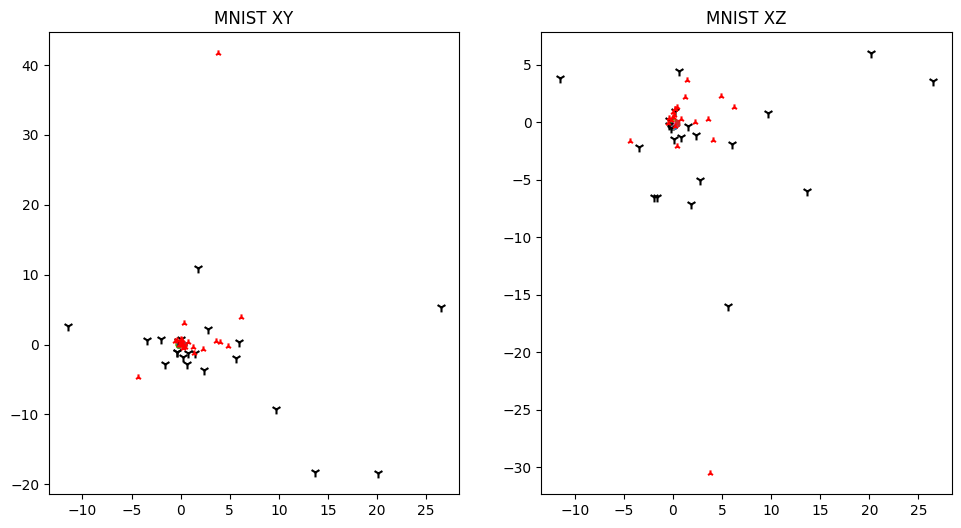

[21624] Reconstruction loss: 45.2178, KLD: 20.9870 AUC 0.9394 FZ 1.0471 FZVOL 0.0090 CENTROIDS DISCREPANCY 7.6249 SHANNON 0.07431721687316895
[21836] Reconstruction loss: 38.4136, KLD: 16.4671 AUC 0.9447 FZ 1.0507 FZVOL 0.0091 CENTROIDS DISCREPANCY 17.9393 SHANNON 0.07446980476379395
[22048] Reconstruction loss: 39.8963, KLD: 17.8638 AUC 0.9406 FZ 1.0567 FZVOL 0.0092 CENTROIDS DISCREPANCY 18238.9634 SHANNON 0.07370734214782715
[22260] Reconstruction loss: 37.4508, KLD: 15.7260 AUC 0.9430 FZ 1.0600 FZVOL 0.0091 CENTROIDS DISCREPANCY 15.9565 SHANNON 0.07343220710754395
[22472] Reconstruction loss: 38.0924, KLD: 15.9878 AUC 0.9447 FZ 1.0668 FZVOL 0.0092 CENTROIDS DISCREPANCY 155.0886 SHANNON 0.07268953323364258


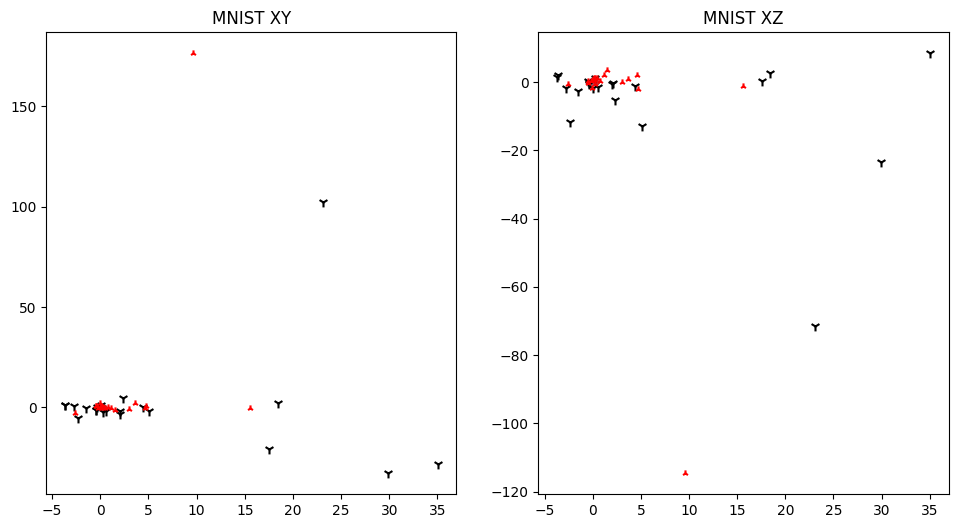

[22684] Reconstruction loss: 40.9493, KLD: 18.5717 AUC 0.9357 FZ 1.0711 FZVOL 0.0091 CENTROIDS DISCREPANCY 30.1720 SHANNON 0.0732426643371582
[22896] Reconstruction loss: 37.2890, KLD: 15.3288 AUC 0.9513 FZ 1.0738 FZVOL 0.0092 CENTROIDS DISCREPANCY 32.1898 SHANNON 0.07190489768981934
[23108] Reconstruction loss: 51.4091, KLD: 25.8306 AUC 0.9171 FZ 1.0791 FZVOL 0.0092 CENTROIDS DISCREPANCY 10.1445 SHANNON 0.0713803768157959
[23320] Reconstruction loss: 38.7035, KLD: 16.4526 AUC 0.9461 FZ 1.0726 FZVOL 0.0092 CENTROIDS DISCREPANCY 9.6194 SHANNON 0.07130885124206543
[23532] Reconstruction loss: 34.8219, KLD: 14.2381 AUC 0.9498 FZ 1.0806 FZVOL 0.0093 CENTROIDS DISCREPANCY 41.2023 SHANNON 0.07078957557678223


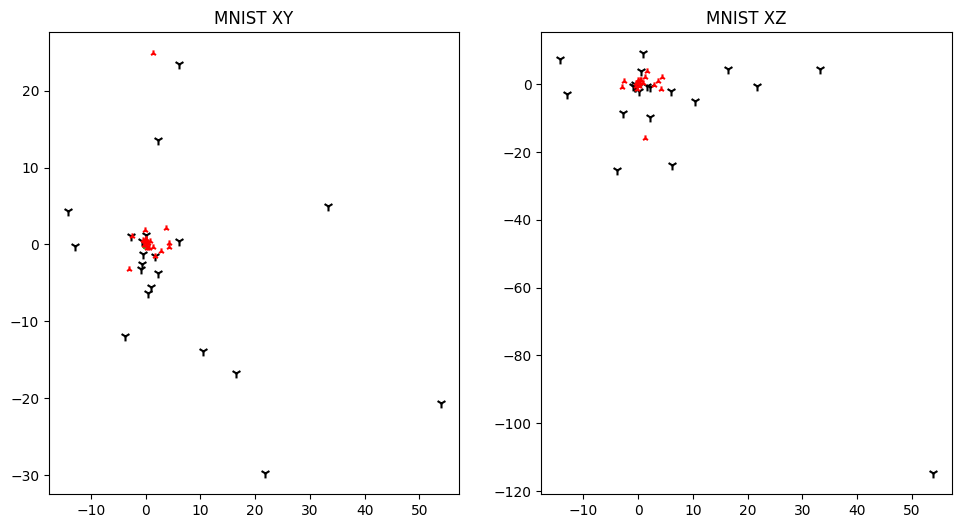

[23744] Reconstruction loss: 40.0522, KLD: 16.8790 AUC 0.9330 FZ 1.0836 FZVOL 0.0094 CENTROIDS DISCREPANCY 48.5898 SHANNON 0.07054305076599121
[23956] Reconstruction loss: 39.8154, KLD: 17.2800 AUC 0.9480 FZ 1.0896 FZVOL 0.0093 CENTROIDS DISCREPANCY 13.8882 SHANNON 0.07011294364929199
[24168] Reconstruction loss: 45.5033, KLD: 21.4612 AUC 0.9326 FZ 1.0930 FZVOL 0.0093 CENTROIDS DISCREPANCY 16.0726 SHANNON 0.0699763298034668
[24380] Reconstruction loss: 43.9309, KLD: 20.0073 AUC 0.9220 FZ 1.0968 FZVOL 0.0093 CENTROIDS DISCREPANCY 29.9644 SHANNON 0.06904292106628418
[24592] Reconstruction loss: 34.2401, KLD: 13.8377 AUC 0.9440 FZ 1.1043 FZVOL 0.0092 CENTROIDS DISCREPANCY 26.3601 SHANNON 0.06866979598999023


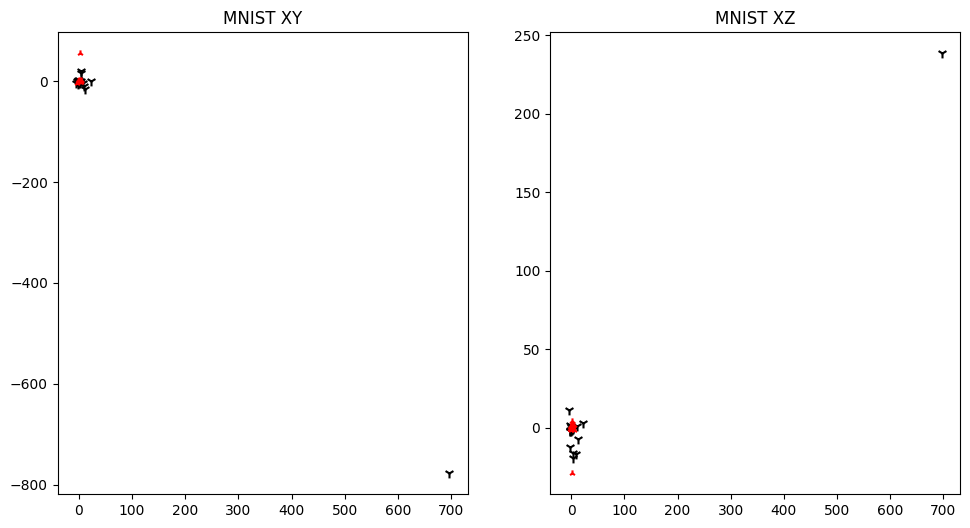

[24804] Reconstruction loss: 36.5342, KLD: 15.4272 AUC 0.9296 FZ 1.1067 FZVOL 0.0093 CENTROIDS DISCREPANCY 2974.6611 SHANNON 0.0678091049194336
[25016] Reconstruction loss: 46.5663, KLD: 22.4381 AUC 0.9513 FZ 1.1093 FZVOL 0.0093 CENTROIDS DISCREPANCY 14.6383 SHANNON 0.06646299362182617
[25228] Reconstruction loss: 44.3493, KLD: 20.5067 AUC 0.9425 FZ 1.1154 FZVOL 0.0094 CENTROIDS DISCREPANCY 19.5714 SHANNON 0.0660088062286377
[25440] Reconstruction loss: 39.2412, KLD: 17.1080 AUC 0.9301 FZ 1.1198 FZVOL 0.0094 CENTROIDS DISCREPANCY 3197.1317 SHANNON 0.06538558006286621
[25652] Reconstruction loss: 37.9075, KLD: 16.3186 AUC 0.9268 FZ 1.1243 FZVOL 0.0094 CENTROIDS DISCREPANCY 25.3091 SHANNON 0.0654141902923584


In [90]:
for epoch in range(num_epochs):
    prev_updates = train(model, train_loader, optimizer, prev_updates, epoch, writer=writer)
    test(model, test_loader, prev_updates, epoch, writer=writer)
    scheduler.step()


In [ ]:
keep_eigenvals_positive_loss(model.decoder.fuzzy[1])

## Визуализируем результаты

In [ ]:

def get_activation_stats(model, dataloader):
    rulestat = {}
    with torch.no_grad():
        for _, (data, _) in enumerate(tqdm(dataloader)):
            data = data.to(device)
            _, _, fz, _ = model.forward(data)
            act_fz = fz.max(-1).indices.cpu().numpy()
            for ind in act_fz:
                rulestat[ind] = rulestat.get(ind, 0) + 1
    return rulestat

train_stat = get_activation_stats(model, train_loader)
test_stat = get_activation_stats(model, test_loader)

plt.bar(list(train_stat.keys()), train_stat.values(), 0.5, color='g')
plt.bar(list(test_stat.keys()), test_stat.values(), 0.5, color='r')

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

train_x = []
test_x = []
test_y = []
with torch.no_grad():
    for _, (data, _) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        fz, _, _, _ = model.forward(data)
        for f in fz:
            train_x.append(f.cpu().numpy())

with torch.no_grad():
    for _, (data, target) in enumerate(tqdm(test_loader)):
        data = data.to(device)
        fz, _, _, _  = model.forward(data)
        for f, trg in zip(fz, target):
            test_x.append(f.cpu().numpy())
            if trg == mnist_class_anomaly:
                test_y.append(-1)
            else:
                test_y.append(1)
    
clf = IsolationForest(random_state=0, n_estimators=1000).fit(train_x)
y_pred =clf.predict(test_x)
disp = ConfusionMatrixDisplay(confusion_matrix(test_y, y_pred))
disp.plot()
accuracy_score(test_y, y_pred)

In [ ]:

def get_activation_stats_by_digit(digit, model, dataloader):
    rulestat = {}
    with torch.no_grad():
        for _, (data, target) in enumerate(tqdm(dataloader)):
        
            data = data.to(device)
            _, _, fz, _ = model.forward(data)
            act_fz = fz.max(-1).indices.cpu().numpy()
            for ind, trg in zip(act_fz, target):
                if trg == digit:
                    rulestat[ind] = rulestat.get(ind, 0) + 1
    return rulestat


test_stat_by_digit = get_activation_stats_by_digit(9, model, test_loader)

plt.bar(list(test_stat_by_digit.keys()), test_stat_by_digit.values(), 0.5, color='r')
plt.xlim((-1, fuzzy_rules_count + 1))

In [ ]:
test_stat_by_digit

In [ ]:
z = torch.randn(64, latent_dim).to(device)
samples, _ = model.decoder_pass(z)

# Plot the generated images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
        ax[i, j].axis('off')


In [ ]:
fz = torch.zeros(64, fuzzy_rules_count).to(device)
for i in range(64):
    fz[i][5] = 1.0/(i+1)

samples = model.decoder.decode_from_fz(fz)

# Plot the generated images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
        ax[i, j].axis('off')

# plt.show()
plt.savefig('cvae_mnist.webp')

In [ ]:
ssim = piqa.SSIM(window_size = 17, n_channels=1, reduction='none').to(device)
def get_arate(inp):
    _, x_recon, x_resd, fz, fz_resd = model.forward(inp)
    dx = (x_recon - inp).abs()

    sim_resd = (1 - ssim((dx/2).clamp(0, 1), (x_resd/2).clamp(0, 1) ))
    sim = (1 - ssim((x_recon + 1)/2, (inp + 1)/2))
    pxdiff = ((x_recon - dx).abs()).sum(-1).sum(-1).squeeze()

    return (sim*sim_resd*pxdiff).cpu().numpy() #(sim).cpu().numpy()#(sim_resd).cpu().numpy()#(1 - ssim((x_recon + 1)/2, (inp + 1)/2)).cpu().numpy()

In [ ]:
firings_mnist = {}
firings_mnist['MNIST'] = []
firings_mnist['DISSIDENT'] = []

with torch.no_grad():
    for data, target in tqdm(test_loader, desc='MNIST HIST'):
        data = data.view((-1,1,28,28)).to(device)
        rates = get_arate(data)
        for f, l in  zip(rates, target):
            if l != mnist_class_anomaly:
                firings_mnist['MNIST'].append(f)
            else:
                firings_mnist['DISSIDENT'].append(f)
        

labels, data = firings_mnist.keys(), firings_mnist.values()

fig = plt.figure(figsize =(12, 2))
plt.boxplot(data, notch=True, showfliers=False)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

writer.add_figure('Anomaly Detection', fig)

In [ ]:
with torch.no_grad():
    firing_levels = []
    lab_true = []
    lab_pred = []

    for data, lab in tqdm(test_loader, desc='Test MNIST', disable=True):
        data = data.view((-1,1,28,28)).to(device)
        rates = get_arate(data)
        
        for f, l in  zip(rates, lab):
            firing_levels.append(f)
            lab_pred.append(f)        
            if l == mnist_class_anomaly:
                lab_true.append(1)
            else:
                lab_true.append(0)
                    
    fpr, tpr, threshold = metrics.roc_curve(lab_true, lab_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    fig = plt.figure(figsize =(4, 4))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    writer.add_figure('ROC', fig)

In [ ]:
def show_plot():
    centroids = model.decoder.fuzzy[1].get_centroids().detach().cpu().numpy()
    embedings = []
    labels_expected = []
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Encoding'):
            data = data.view((-1,1,28,28)).to(device)
            embeding,_,_, _,_ = model.forward(data)
            embedings.append(embeding.cpu().numpy())
            labels_expected.append(target.cpu().numpy())
    embedings = np.concatenate(embedings, axis=0)
    labels_expected = np.concatenate(labels_expected, axis=0)

    plt.figure(figsize=(18, 6))

    R, C = 1, 3

    plt.subplot(R, C, 1)
    plt.title("MNIST XY")
    plt.scatter(embedings[:, 0],      embedings[:,  1], c=labels_expected, cmap='tab10', s=2)
    #plt.scatter(centroids[:, 0],      centroids[:, 1], marker='1', c='black', s= 50)

    plt.subplot(R, C, 2)
    plt.title("MNIST XZ")
    plt.scatter(embedings[:, 0],      embedings[:,  2], c=labels_expected, cmap='tab10', s=2)
    #plt.scatter(centroids[:, 0],      centroids[:, 2], marker='1', c='black', s= 50)

    
show_plot()

In [ ]:
def show_item_reconstructio(ind):
    for data, trg in iter(test_loader):
        data = data.to(device)
        _, x_rec, x_resd, fz, fz_resd = model.forward(data)

        plt.figure(figsize=(24, 6))

        R, C = 1, 5

        plt.subplot(R, C, 1)
        plt.bar(range(fuzzy_rules_count), fz[ind].detach().cpu().numpy())
        plt.subplot(R, C, 2)
        plt.imshow(data[ind].cpu().squeeze())
        plt.subplot(R, C, 3)
        plt.imshow(x_rec[ind].detach().cpu().squeeze())
        plt.subplot(R, C, 4)
        plt.imshow(x_resd[ind].detach().cpu().squeeze())
        plt.subplot(R, C, 4)
        plt.imshow(((data[ind]-x_rec[ind]).abs() - x_resd[ind]).abs().clamp(min=0.2).abs().detach().cpu().squeeze())
        break

In [ ]:
show_item_reconstructio(4)
show_item_reconstructio(3)